In [1]:
from data import CIFAR10
from model import Model

Using TensorFlow backend.


In [2]:
def eval_hidden(m, d):
    bs = 100
    nh = m.sizes[-1]
    result = np.zeros([d.shape[0], nh])
    print result.shape
    
    for i in range(d.shape[0]/bs):
        st = i*bs
        en = (i+1)*bs
        result[st:en,:] = m.eval_hidden([d[st:en,:]])[0]
    return result

In [8]:
m = Model(256, 128, 64, 128, 0)
#m.load('model_128_64_32_128')

d = CIFAR10()

In [ ]:
m.fit(d, epochs=100)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 46s 927us/step - loss: 0.0394 - val_loss: 0.0175
Epoch 2/100
50000/50000 [==============================] - 45s 890us/step - loss: 0.0158 - val_loss: 0.0146
Epoch 3/100
50000/50000 [==============================] - 46s 910us/step - loss: 0.0139 - val_loss: 0.0130
Epoch 4/100
50000/50000 [==============================] - 46s 912us/step - loss: 0.0128 - val_loss: 0.0124
Epoch 5/100
50000/50000 [==============================] - 46s 919us/step - loss: 0.0119 - val_loss: 0.0113
Epoch 6/100
50000/50000 [==============================] - 46s 925us/step - loss: 0.0113 - val_loss: 0.0115
Epoch 7/100
50000/50000 [==============================] - 46s 918us/step - loss: 0.0109 - val_loss: 0.0105
Epoch 8/100
50000/50000 [==============================] - 46s 919us/step - loss: 0.0106 - val_loss: 0.0103
Epoch 9/100
50000/50000 [==============================] - 46s 915us/step - loss: 0.01

In [ ]:
m.save('model_256_128_64_218')

In [42]:
x=eval_hidden(m, d.test_x)

(10000, 512)


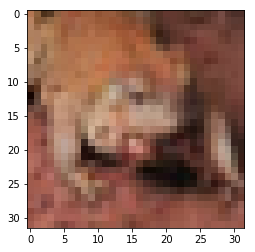

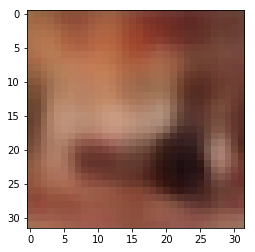

In [7]:
%matplotlib inline
m.comp(5, d.test_x)